In [1]:
import gym
import numpy as np

env = gym.make('ALE/Pong-v5', frameskip=4)
observation = env.reset()
print(env.action_space.n)
print(env.observation_space.shape)
print(np.shape(observation))
state = []

6
(210, 160, 3)
(210, 160, 3)


C:\Users\Student\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
C:\Users\Student\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


Populating the interactive namespace from numpy and matplotlib
torch.Size([2, 84, 84])


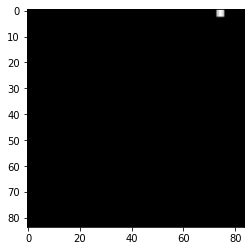

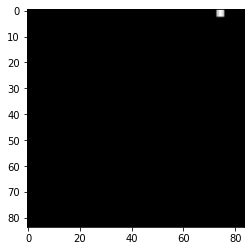

torch.Size([2, 84, 84])


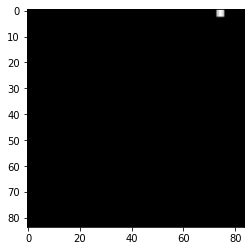

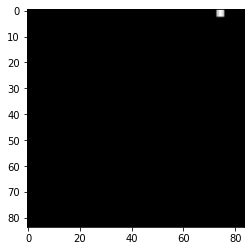

torch.Size([2, 84, 84])


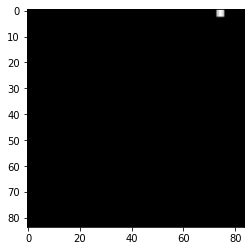

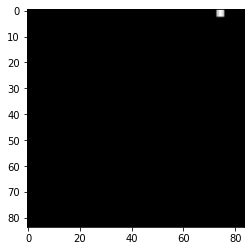

torch.Size([2, 84, 84])


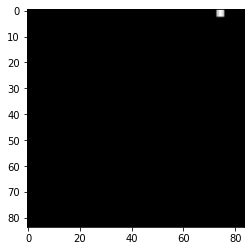

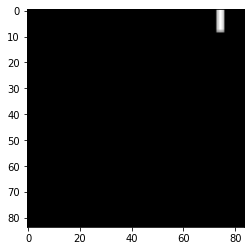

torch.Size([2, 84, 84])


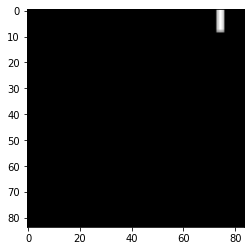

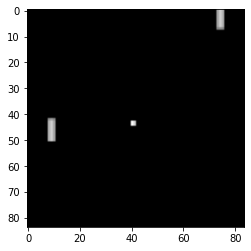

torch.Size([2, 84, 84])


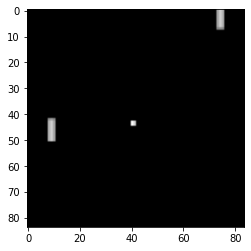

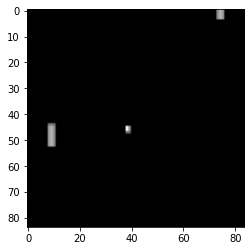

torch.Size([2, 84, 84])


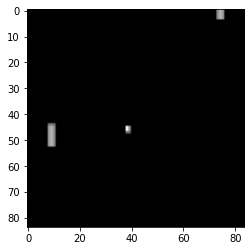

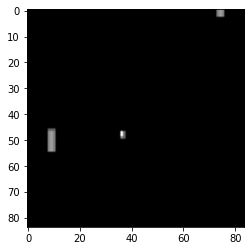

torch.Size([2, 84, 84])


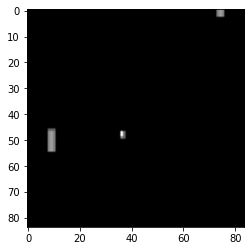

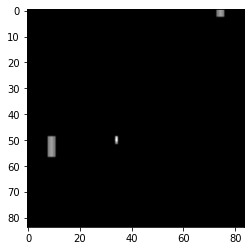

torch.Size([2, 84, 84])


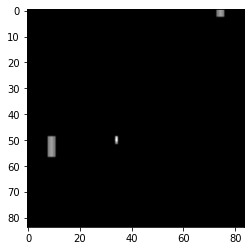

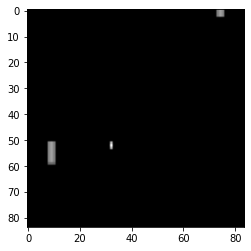

torch.Size([2, 84, 84])


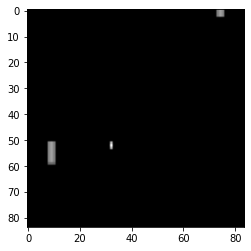

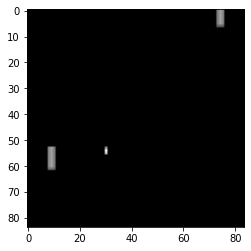

torch.Size([2, 84, 84])


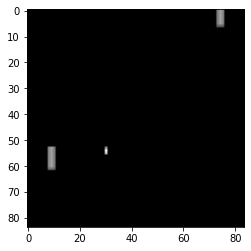

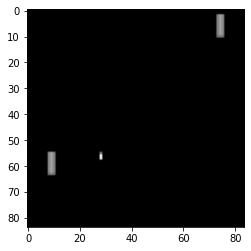

torch.Size([2, 84, 84])


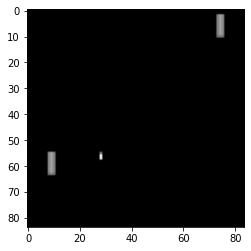

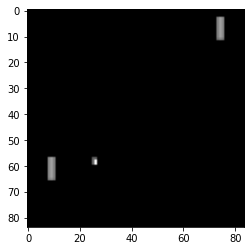

torch.Size([2, 84, 84])


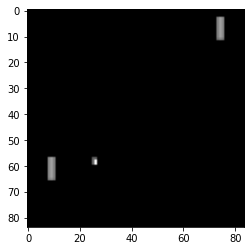

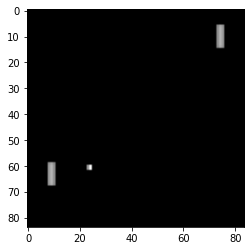

torch.Size([2, 84, 84])


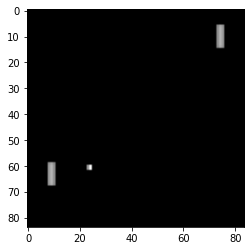

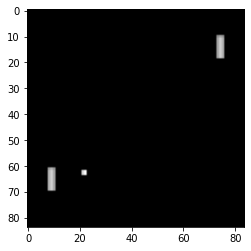

torch.Size([2, 84, 84])


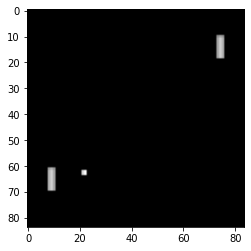

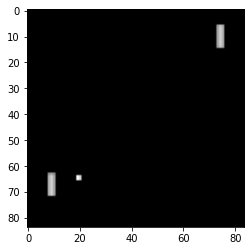

torch.Size([2, 84, 84])


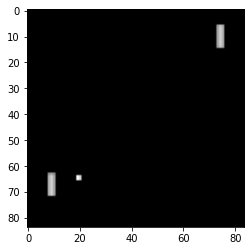

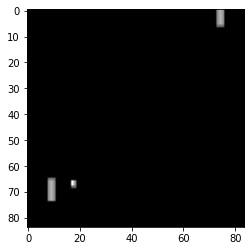

torch.Size([2, 84, 84])


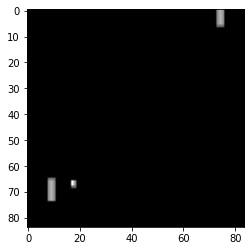

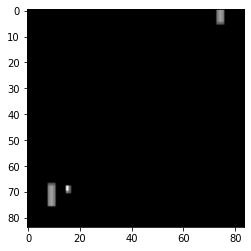

torch.Size([2, 84, 84])


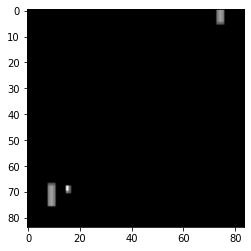

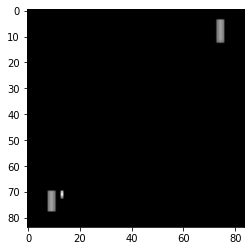

torch.Size([2, 84, 84])


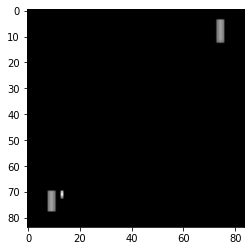

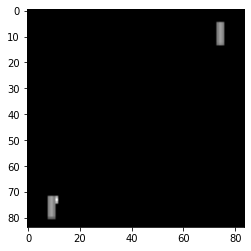

torch.Size([2, 84, 84])


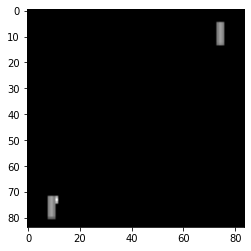

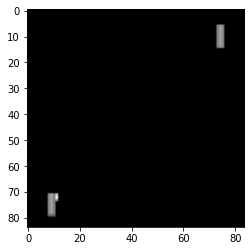

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch import nn
import math

def rgb2grey(rgb):
    return np.dot(rgb[33:193][:][...,:3], [0.2989, 0.5870, 0.1140])

from torchvision.transforms import functional

def inv(frame):
    new_frame = []
    for line in frame:
        new_frame.append([])
        for item in line:
            new_frame[-1].append(255-item)
            
    return torch.Tensor(new_frame)

def process(rgb):
    frame = rgb[34:194][:][:]
    transposed = frame.transpose(2, 0, 1)
    as_tensor = torch.Tensor(transposed)
    grey = functional.rgb_to_grayscale(as_tensor)
    downsampled = functional.resize(grey, [84, 84])
    thresh = nn.Threshold(87.3, 0)
    background_removed = thresh(downsampled)
    state.append(background_removed)
    
    if (len(state) > 2):
        state.pop(0)
    #print(numpy.shape(torch.flatten(torch.stack(state).squeeze(1), 0, -1)))
    return torch.stack(state).squeeze(1)

for n in range(10):
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    img_pre = process(observation)
    
for n in range(20):
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    img_pre = process(observation)
    print(np.shape(img_pre))
    imgplot = plt.imshow(img_pre[0], cmap="gray")
    plt.show()
    imgplot = plt.imshow(img_pre[1], cmap="gray")
    plt.show()

In [3]:
import torch
from torch import nn
from torch import optim

#class for the neural network
class neural_network(nn.Module):
    def __init__(self, env):
        super().__init__()
        #get number of actions & observations for output & input layer resp.
        self.n_actions = 3
        self.n_observations = 900
        print("Number actions: " + str(self.n_actions))
        print("Number observations: " + str(self.n_observations))
       # self.network = nn.Sequential(
        #    nn.Linear(self.n_observations, 32), 
         #   #nn.ReLU(), 
          #  nn.Linear(32, self.n_actions),
           # nn.Softmax(dim=-1))
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=4, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
           # nn.Conv2d(in_channels=4, out_channels = 8, kernel_size=5, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(1600, 800),
            nn.ReLU(),
            nn.Linear(800, 400),
            nn.Linear(400, self.n_actions),
            nn.Softmax(dim=-1)
        )
        
        
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 1600)  # reduce the dimensions for linear layer input
        x = x.squeeze(0)
        return self.classifier(x)
                    
    def predict(self, state):
        #print(type(state))
        action_probabilities = self.forward(state)
        return action_probabilities

In [4]:
#function for discounted return

def calculate_discounted_return(rewards, discount_factor):
    discounted_returns = [rewards[-1]]
    
    for i in range(len(rewards)-2, -1, -1):
        discounted_returns.append(rewards[i] + (discount_factor*discounted_returns[-1]))
    
    discounted_returns.reverse()
    return discounted_returns
    #return discounted_returns

In [ ]:
import random
import numpy

#initialise parameters
alpha = 0.0001
discount_factor = 0.9
#initialise policy network pi with parameters theta 
#DOES IT MATTER WHAT IT ORIGINALLY OUTPUTS - SOME ACTIONS ARE HIGHLY PREFERED BY DEFAULT
#YEAH ACTIONS SEEM TO ONLY BE ACTUALLY CHOOSING BETWEEN TWO IDK IF THIS HURTS TRAINING
n_network = neural_network(env)
network_optimiser = optim.Adam(n_network.parameters(), lr=alpha)
available_actions = [0,2,3]
print(available_actions)

num_episodes = 10000
batch_size = 10
episode_rewards = []
total_rewards = []
batch_log_probs = []
batch_actions = []
batch_rewards = []
batch_count = 0

for episode in range(num_episodes):
    print("EPISODE " + str(episode))
    #generate an episode trajectory following policy pi
    episode_rewards.append(0)
    observation = env.reset()
    cur_state = process(observation)
    cur_state = process(observation)
    #cur_state = process(observation)
    #cur_state = process(observation)
   # print(cur_state)
    done = False
    first = True
    turn = 0
    
    states = []
    rewards = []
    actions = []
    log_probs = []
    
    while not done:
        action_probs = n_network.predict(cur_state)
        if turn % 400 == 0:
            print(action_probs)
        turn += 1
        action = random.choices(available_actions, weights=action_probs.tolist())[0]
        actions.append(action)
        if action == 2:
            action_index = 1
        elif action == 3:
            action_index = 2
        else:
            action_index = 0
        log_probs.append(torch.log(action_probs.squeeze(0))[action_index])
        observation, reward, done, info = env.step(action)
        
        if reward > 0:
            print("Reward!: ", reward)

        states.append(cur_state)
        cur_state = process(observation)
        rewards.append(reward)
        episode_rewards[episode] += reward
        
        if done:
            discounted_returns = calculate_discounted_return(rewards, discount_factor)
            batch_rewards.extend(discounted_returns)
            batch_log_probs.extend(log_probs)
            batch_count += 1
            total_rewards.append(sum(rewards))
            print(total_rewards[-1])
            
            if batch_count == batch_size:
                network_optimiser.zero_grad()
                
                reward_tensor = torch.Tensor(batch_rewards)
                chosen_log_probs = torch.stack(batch_log_probs)#.detach().numpy()
                
                log_x_reward = reward_tensor * chosen_log_probs
                loss = - log_x_reward.mean()
                
                loss.backward()
                print("Loss: ", loss)
                network_optimiser.step()
                
                batch_rewards = []
                batch_log_probs = []
                batch_count = 0

Number actions: 3
Number observations: 900
[0, 2, 3]
EPISODE 0
tensor([9.9205e-01, 3.3634e-08, 7.9510e-03], grad_fn=<SoftmaxBackward0>)
tensor([0.8152, 0.0704, 0.1144], grad_fn=<SoftmaxBackward0>)
tensor([0.9920, 0.0033, 0.0047], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 1
tensor([9.9205e-01, 3.3634e-08, 7.9510e-03], grad_fn=<SoftmaxBackward0>)
tensor([0.9441, 0.0244, 0.0315], grad_fn=<SoftmaxBackward0>)
tensor([0.9382, 0.0474, 0.0144], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 2
tensor([9.9205e-01, 3.3634e-08, 7.9510e-03], grad_fn=<SoftmaxBackward0>)
tensor([0.5418, 0.0976, 0.3606], grad_fn=<SoftmaxBackward0>)
tensor([0.6400, 0.0264, 0.3335], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 3
tensor([9.9205e-01, 3.3634e-08, 7.9510e-03], grad_fn=<SoftmaxBackward0>)
tensor([0.9781, 0.0058, 0.0161], grad_fn=<SoftmaxBackward0>)
tensor([0.2706, 0.2902, 0.4391], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
-20.0
EPISODE 4
tensor([9.9205e-01, 3.3634e-08, 7.9510e-03], grad_fn=<SoftmaxBackward0>)
tensor

tensor([0.3935, 0.2631, 0.3434], grad_fn=<SoftmaxBackward0>)
tensor([0.9473, 0.0487, 0.0040], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 37
tensor([9.9786e-01, 3.4647e-07, 2.1365e-03], grad_fn=<SoftmaxBackward0>)
tensor([0.9666, 0.0317, 0.0017], grad_fn=<SoftmaxBackward0>)
tensor([0.9765, 0.0172, 0.0063], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 38
tensor([9.9786e-01, 3.4647e-07, 2.1365e-03], grad_fn=<SoftmaxBackward0>)
tensor([0.9828, 0.0134, 0.0038], grad_fn=<SoftmaxBackward0>)
tensor([0.9975, 0.0014, 0.0011], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 39
tensor([9.9786e-01, 3.4647e-07, 2.1365e-03], grad_fn=<SoftmaxBackward0>)
tensor([0.9821, 0.0060, 0.0119], grad_fn=<SoftmaxBackward0>)
tensor([0.9853, 0.0072, 0.0075], grad_fn=<SoftmaxBackward0>)
-21.0
Loss:  tensor(-0.0541, grad_fn=<NegBackward0>)
EPISODE 40
tensor([9.8643e-01, 1.9546e-07, 1.3565e-02], grad_fn=<SoftmaxBackward0>)
tensor([0.9847, 0.0108, 0.0045], grad_fn=<SoftmaxBackward0>)
tensor([9.9911e-01, 4.1136e-04, 4.8339e-04],

tensor([9.9781e-01, 2.0516e-03, 1.3953e-04], grad_fn=<SoftmaxBackward0>)
tensor([0.9893, 0.0056, 0.0051], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 72
tensor([9.8953e-01, 9.3128e-09, 1.0472e-02], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([9.9691e-01, 2.9708e-03, 1.1560e-04], grad_fn=<SoftmaxBackward0>)
tensor([0.9906, 0.0053, 0.0041], grad_fn=<SoftmaxBackward0>)
-20.0
EPISODE 73
tensor([9.8953e-01, 9.3128e-09, 1.0472e-02], grad_fn=<SoftmaxBackward0>)
tensor([9.9932e-01, 2.1882e-04, 4.5828e-04], grad_fn=<SoftmaxBackward0>)
tensor([9.9247e-01, 7.1403e-03, 3.9453e-04], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 74
tensor([9.8953e-01, 9.3128e-09, 1.0472e-02], grad_fn=<SoftmaxBackward0>)
tensor([0.9956, 0.0028, 0.0016], grad_fn=<SoftmaxBackward0>)
tensor([9.9606e-01, 3.3805e-03, 5.5662e-04], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 75
tensor([9.8953e-01, 9.3128e-09, 1.0472e-02], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([9.9872e-01, 5.4303e-04, 7.3987e-04], grad_fn=<SoftmaxBac

-21.0
EPISODE 106
tensor([9.4020e-01, 8.4978e-08, 5.9805e-02], grad_fn=<SoftmaxBackward0>)
tensor([9.9377e-01, 5.9220e-03, 3.0492e-04], grad_fn=<SoftmaxBackward0>)
tensor([9.9567e-01, 4.9859e-04, 3.8283e-03], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 107
tensor([9.4020e-01, 8.4978e-08, 5.9805e-02], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.1305, 0.5704, 0.2992], grad_fn=<SoftmaxBackward0>)
tensor([0.9794, 0.0188, 0.0018], grad_fn=<SoftmaxBackward0>)
-20.0
EPISODE 108
tensor([9.4020e-01, 8.4978e-08, 5.9805e-02], grad_fn=<SoftmaxBackward0>)
tensor([0.9685, 0.0187, 0.0128], grad_fn=<SoftmaxBackward0>)
tensor([0.8881, 0.0202, 0.0917], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 109
tensor([9.4020e-01, 8.4978e-08, 5.9805e-02], grad_fn=<SoftmaxBackward0>)
tensor([9.8066e-01, 1.8620e-02, 7.2184e-04], grad_fn=<SoftmaxBackward0>)
tensor([9.9377e-01, 5.9220e-03, 3.0492e-04], grad_fn=<SoftmaxBackward0>)
-21.0
Loss:  tensor(-0.0496, grad_fn=<NegBackward0>)
EPISODE 110
tensor([9.0765e-01, 3

-21.0
EPISODE 139
tensor([4.2490e-01, 1.4962e-05, 5.7509e-01], grad_fn=<SoftmaxBackward0>)
tensor([2.4533e-01, 7.5428e-01, 3.8129e-04], grad_fn=<SoftmaxBackward0>)
tensor([0.1319, 0.6599, 0.2083], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
-20.0
Loss:  tensor(-0.0800, grad_fn=<NegBackward0>)
EPISODE 140
tensor([2.2721e-01, 1.1862e-04, 7.7267e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.8931, 0.0542, 0.0527], grad_fn=<SoftmaxBackward0>)
tensor([0.3218, 0.0157, 0.6625], grad_fn=<SoftmaxBackward0>)
tensor([0.1936, 0.7932, 0.0132], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 141
tensor([2.2721e-01, 1.1862e-04, 7.7267e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.1341, 0.4117, 0.4542], grad_fn=<SoftmaxBackward0>)
tensor([0.0652, 0.1752, 0.7596], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 142
tensor([2.2721e-01, 1.1862e-04, 7.7267e-01], grad_fn=<SoftmaxBackward0>)
tensor([6.5933e-03, 9.9252e-01, 8.8879e-04], grad_fn=<SoftmaxBackward0>)
tensor([0.1518, 0.2153, 0.6330], grad_fn=<SoftmaxBackward0>)
-2

tensor([0.9011, 0.0304, 0.0685], grad_fn=<SoftmaxBackward0>)
tensor([0.0174, 0.0671, 0.9155], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 172
tensor([8.6046e-02, 2.0036e-05, 9.1393e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.7029, 0.2343, 0.0627], grad_fn=<SoftmaxBackward0>)
tensor([9.9826e-01, 3.8052e-04, 1.3629e-03], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 173
tensor([8.6046e-02, 2.0036e-05, 9.1393e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.0103, 0.0122, 0.9775], grad_fn=<SoftmaxBackward0>)
tensor([0.0185, 0.1110, 0.8705], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 174
tensor([8.6046e-02, 2.0036e-05, 9.1393e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.9792, 0.0095, 0.0112], grad_fn=<SoftmaxBackward0>)
tensor([0.8522, 0.1432, 0.0046], grad_fn=<SoftmaxBackward0>)
tensor([0.0329, 0.9658, 0.0012], grad_fn=<SoftmaxBackward0>)
tensor([6.4446e-04, 9.9920e-01, 1.5490e-04], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 175
tensor([8.6046e-02, 2.0036e-05, 9.1393e-01], grad_fn=<SoftmaxBackward0>)
te

tensor([0.4330, 0.4666, 0.1005], grad_fn=<SoftmaxBackward0>)
tensor([0.0857, 0.0162, 0.8981], grad_fn=<SoftmaxBackward0>)
tensor([0.0039, 0.7853, 0.2107], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
-20.0
Loss:  tensor(-0.0535, grad_fn=<NegBackward0>)
EPISODE 200
tensor([5.3664e-02, 2.5407e-06, 9.4633e-01], grad_fn=<SoftmaxBackward0>)
tensor([9.9418e-01, 5.7185e-03, 9.8707e-05], grad_fn=<SoftmaxBackward0>)
tensor([0.0354, 0.0143, 0.9503], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
Reward!:  1.0
tensor([0.3919, 0.0485, 0.5596], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
-18.0
EPISODE 201
tensor([5.3664e-02, 2.5407e-06, 9.4633e-01], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.9757, 0.0075, 0.0168], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.0042, 0.6265, 0.3694], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.4228, 0.0016, 0.5756], grad_fn=<SoftmaxBackward0>)
-18.0
EPISODE 202
tensor([5.3664e-02, 2.5407e-06, 9.4633e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.0032, 0.943

-20.0
EPISODE 225
tensor([2.0216e-02, 4.8331e-06, 9.7978e-01], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.5996, 0.3981, 0.0023], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.0041, 0.1199, 0.8761], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([1.7925e-05, 9.9102e-01, 8.9635e-03], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
-17.0
EPISODE 226
tensor([2.0216e-02, 4.8331e-06, 9.7978e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.8979, 0.0872, 0.0149], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.5121, 0.4730, 0.0148], grad_fn=<SoftmaxBackward0>)
tensor([0.1420, 0.1193, 0.7387], grad_fn=<SoftmaxBackward0>)
tensor([9.9091e-01, 8.9643e-03, 1.2149e-04], grad_fn=<SoftmaxBackward0>)
-20.0
EPISODE 227
tensor([2.0216e-02, 4.8331e-06, 9.7978e-01], grad_fn=<SoftmaxBackward0>)
tensor([2.1821e-04, 4.9668e-02, 9.5011e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.4791, 0.4726, 0.0483], grad_fn=<SoftmaxBackward0>)
tensor([3.0781e-04, 9.8052e-01, 1.9169e-02], grad_fn=<SoftmaxBackward0>)

-20.0
EPISODE 248
tensor([4.7424e-03, 4.9037e-06, 9.9525e-01], grad_fn=<SoftmaxBackward0>)
tensor([1.4062e-04, 9.7636e-01, 2.3495e-02], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.0708, 0.0023, 0.9270], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
Reward!:  1.0
tensor([0.0325, 0.0021, 0.9654], grad_fn=<SoftmaxBackward0>)
tensor([0.9555, 0.0262, 0.0183], grad_fn=<SoftmaxBackward0>)
-18.0
EPISODE 249
tensor([4.7424e-03, 4.9037e-06, 9.9525e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.0497, 0.9485, 0.0018], grad_fn=<SoftmaxBackward0>)
tensor([0.7740, 0.1843, 0.0417], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([6.2192e-08, 9.9987e-01, 1.3320e-04], grad_fn=<SoftmaxBackward0>)
tensor([0.0588, 0.7729, 0.1683], grad_fn=<SoftmaxBackward0>)
-20.0
Loss:  tensor(-0.0437, grad_fn=<NegBackward0>)
EPISODE 250
tensor([1.5136e-03, 1.6633e-06, 9.9848e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.0463, 0.2050, 0.7487], grad_fn=<SoftmaxBackward0>)
tensor([0.0722, 0.0053, 0.9225], grad_fn=<SoftmaxBa

tensor([4.5052e-04, 2.7189e-04, 9.9928e-01], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([5.3735e-05, 8.7251e-01, 1.2743e-01], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.9851, 0.0061, 0.0089], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
-18.0
EPISODE 271
tensor([8.1025e-05, 1.7536e-07, 9.9992e-01], grad_fn=<SoftmaxBackward0>)
tensor([4.9211e-04, 7.7941e-01, 2.2009e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.8878, 0.1067, 0.0055], grad_fn=<SoftmaxBackward0>)
tensor([6.3556e-04, 1.0303e-03, 9.9833e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.0030, 0.0089, 0.9880], grad_fn=<SoftmaxBackward0>)
-21.0
EPISODE 272
tensor([8.1025e-05, 1.7536e-07, 9.9992e-01], grad_fn=<SoftmaxBackward0>)
tensor([0.0023, 0.0530, 0.9446], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.2343, 0.7643, 0.0014], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
Reward!:  1.0
tensor([0.2270, 0.2332, 0.5398], grad_fn=<SoftmaxBackward0>)
-18.0
EPISODE 273
tensor([8.1025e-05, 1.7536e-07, 9.9992e-01], grad_fn=<Soft

tensor([0.5682, 0.2168, 0.2150], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.0084, 0.7479, 0.2436], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.6215, 0.2593, 0.1192], grad_fn=<SoftmaxBackward0>)
tensor([0.9709, 0.0264, 0.0027], grad_fn=<SoftmaxBackward0>)
-19.0
EPISODE 292
tensor([2.8556e-05, 4.1371e-08, 9.9997e-01], grad_fn=<SoftmaxBackward0>)
tensor([7.2625e-04, 9.5463e-01, 4.4645e-02], grad_fn=<SoftmaxBackward0>)
tensor([0.0254, 0.0020, 0.9726], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([0.0151, 0.4105, 0.5744], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
Reward!:  1.0
tensor([0.0010, 0.8758, 0.1232], grad_fn=<SoftmaxBackward0>)
tensor([0.8624, 0.1292, 0.0084], grad_fn=<SoftmaxBackward0>)
-18.0
EPISODE 293
tensor([2.8556e-05, 4.1371e-08, 9.9997e-01], grad_fn=<SoftmaxBackward0>)
Reward!:  1.0
tensor([9.4880e-04, 9.9679e-01, 2.2576e-03], grad_fn=<SoftmaxBackward0>)
tensor([6.1089e-05, 9.7985e-01, 2.0086e-02], grad_fn=<SoftmaxBackward0>)
tensor([0.0288, 0.9654, 0.0

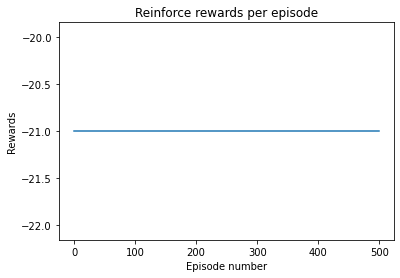

In [31]:
import matplotlib.pyplot as plt
 
plt.plot(episode_rewards)
 
plt.xlabel('Episode number')
plt.ylabel('Rewards')
 
# giving a title to my graph
plt.title('Reinforce rewards per episode')
 
# function to show the plot
plt.show()

GREY IMAGE PROCESS


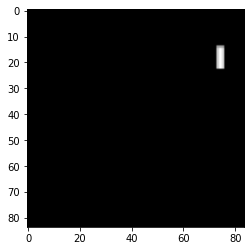

torch.Size([84, 84])


In [3]:
for n in range(10):
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    img_pre = process(observation)
grey_image = img_pre[0]
print("GREY IMAGE PROCESS")
#print(np.amax(grey_image))
imgplot = plt.imshow(grey_image, cmap="gray")
plt.show()
print(np.shape(grey_image))
#f = open("image.txt", "w")
#pic = list(grey_image.detach().numpy().round(decimals=2))
#for element in pic:
 #   print(element, file=f)

torch.Size([900])


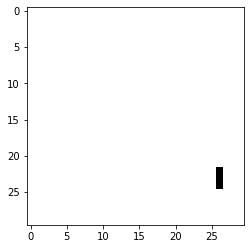

torch.Size([900])


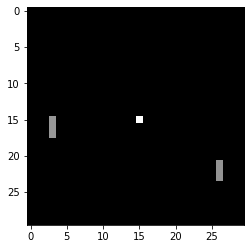

torch.Size([900])


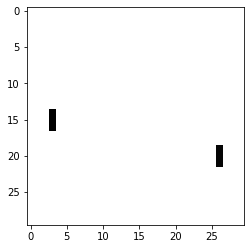

torch.Size([900])


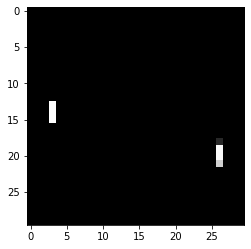

torch.Size([900])


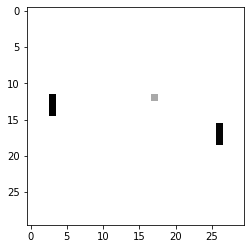

torch.Size([900])


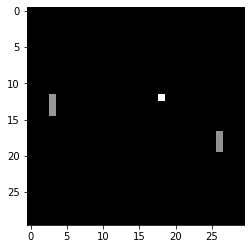

torch.Size([900])


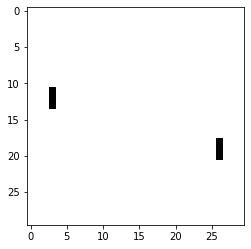

torch.Size([900])


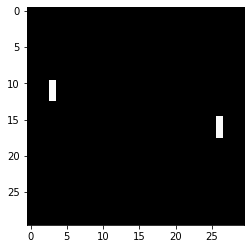

torch.Size([900])


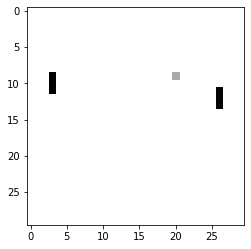

torch.Size([900])


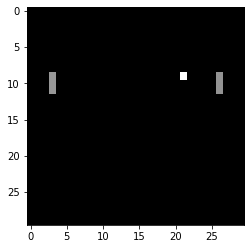

torch.Size([900])


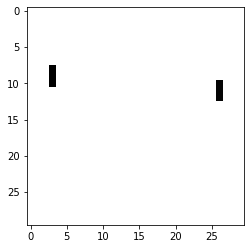

torch.Size([900])


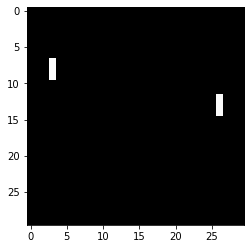

torch.Size([900])


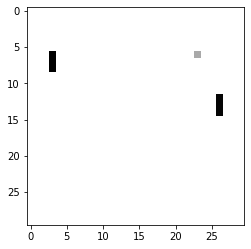

torch.Size([900])


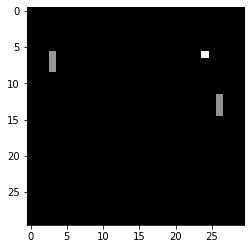

torch.Size([900])


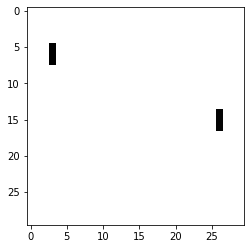

torch.Size([900])


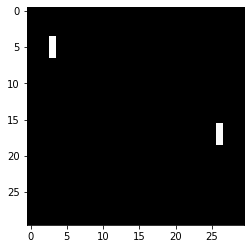

torch.Size([900])


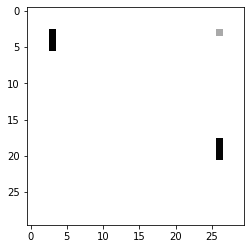

torch.Size([900])


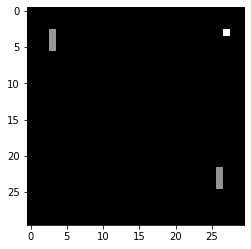

torch.Size([900])


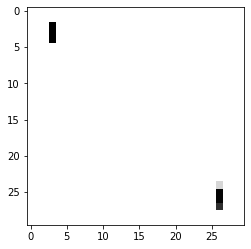

torch.Size([900])


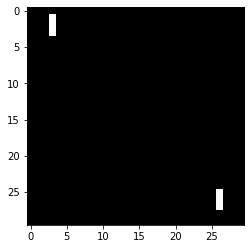

torch.Size([900])


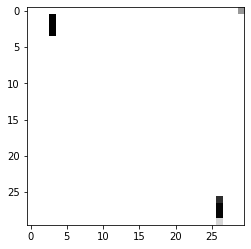

torch.Size([900])


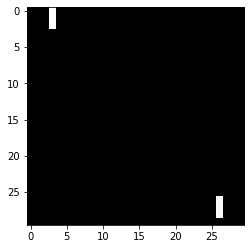

torch.Size([900])


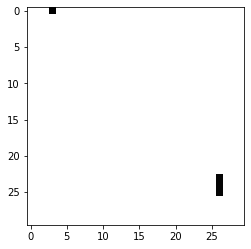

torch.Size([900])


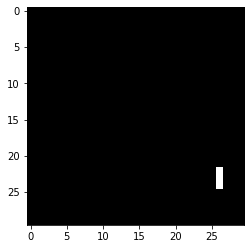

torch.Size([900])


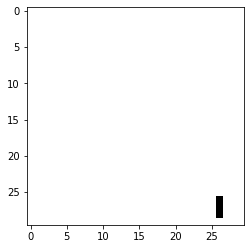

torch.Size([900])


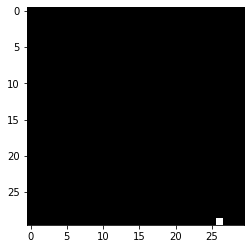

torch.Size([900])


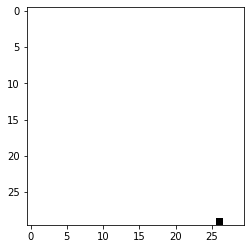

torch.Size([900])


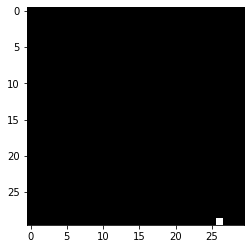

torch.Size([900])


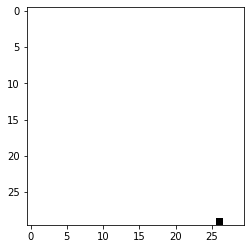

torch.Size([900])


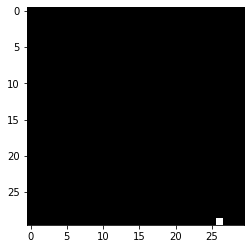

torch.Size([900])


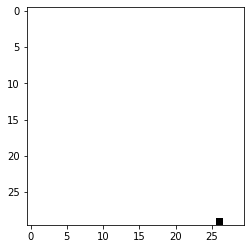

torch.Size([900])


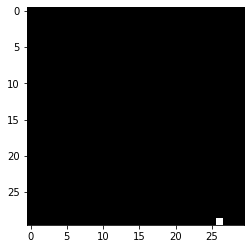

torch.Size([900])


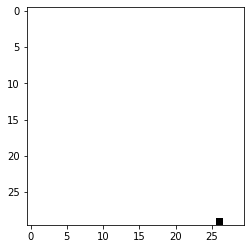

torch.Size([900])


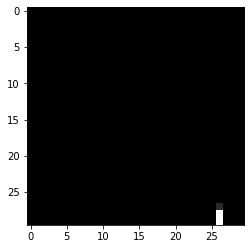

torch.Size([900])


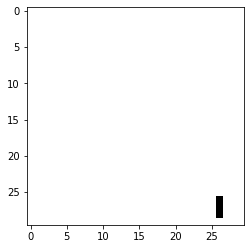

torch.Size([900])


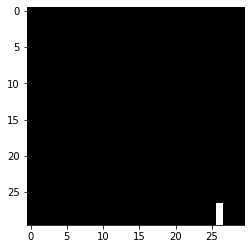

torch.Size([900])


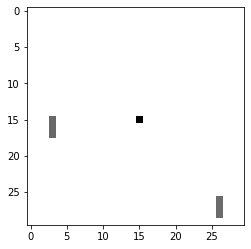

torch.Size([900])


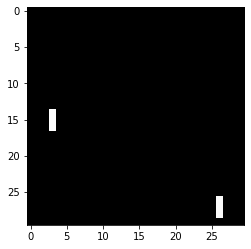

torch.Size([900])


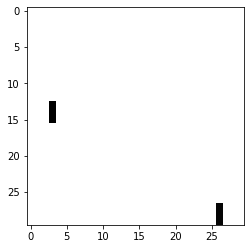

torch.Size([900])


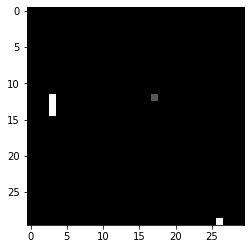

torch.Size([900])


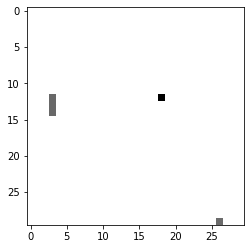

torch.Size([900])


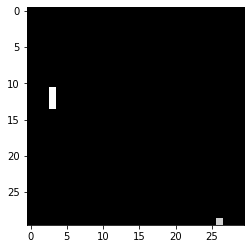

torch.Size([900])


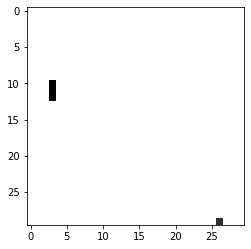

torch.Size([900])


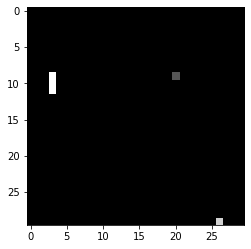

torch.Size([900])


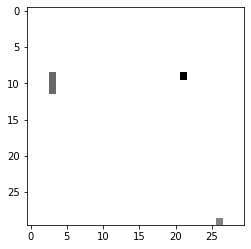

torch.Size([900])


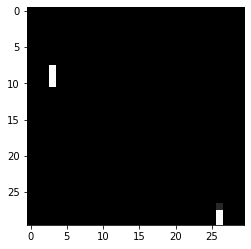

torch.Size([900])


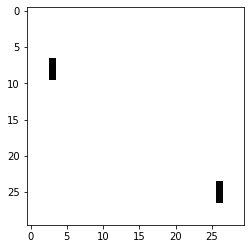

torch.Size([900])


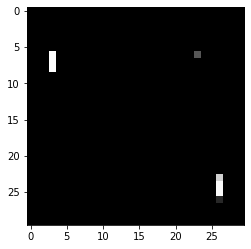

torch.Size([900])


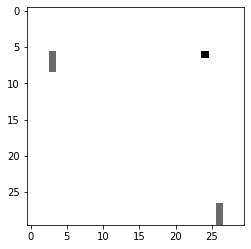

torch.Size([900])


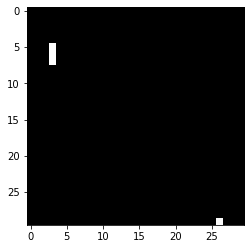

In [29]:
for n in range(50):
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    if n % 2 == 0:
        img_pre = process(observation, True)
    else:
        img_pre = process(observation, False)
    imgplot = plt.imshow(img_pre[0], cmap="gray")
    plt.show()

Populating the interactive namespace from numpy and matplotlib
GREY IMAGE PROCESS


C:\Users\Student\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['inv']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


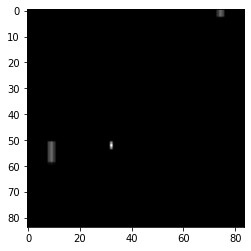

torch.Size([84, 84])
tensor([[87.2436, 87.2436, 87.2436,  ..., 87.2436, 87.2436, 87.2436],
        [87.2436, 87.2436, 87.2436,  ..., 87.2436, 87.2436, 87.2436],
        [87.2436, 87.2436, 87.2436,  ..., 87.2436, 87.2436, 87.2436],
        ...,
        [87.2436, 87.2436, 87.2436,  ..., 87.2436, 87.2436, 87.2436],
        [87.2436, 87.2436, 87.2436,  ..., 87.2436, 87.2436, 87.2436],
        [87.2436, 87.2436, 87.2436,  ..., 87.2436, 87.2436, 87.2436]])


RuntimeError: Given groups=1, weight of size [1, 1, 3, 3], expected input[1, 2, 84, 84] to have 1 channels, but got 2 channels instead

In [3]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch import nn

#transposed = observation.transpose(2, 0, 1

conv2 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=8, stride=4)
network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1))
            #nn.ReLU())
            #nn.MaxPool2d(kernel_size=4, stride=2),
            #nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            #nn.ReLU())
            #nn.MaxPool2d(kernel_size=2, stride=1))
            #nn.BatchNorm2d(16))

networ2k = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=96, kernel_size=10, stride=3),  # (b x 96 x 55 x 55)
            nn.LeakyReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 27 x 27)
            nn.Conv2d(96, 256, 5, padding=2),  # (b x 256 x 27 x 27)
            #nn.LeakyReLU(),
            #nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            #nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 13 x 13)
            #nn.Conv2d(256, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            #nn.LeakyReLU(),
            #nn.Conv2d(384, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            #nn.LeakyReLU(),
            #nn.Conv2d(384, 256, 3, padding=1),  # (b x 256 x 13 x 13)
            #nn.LeakyReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
        )
for n in range(10):
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    img_pre = process(observation)

last_space = [0,0]

for n in range(10):
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    img_pre = process(observation)
grey_image = img_pre[0]
print("GREY IMAGE PROCESS")
#print(np.amax(grey_image))
imgplot = plt.imshow(grey_image, cmap="gray")
plt.show()
print(np.shape(grey_image))
print(grey_image)

fc = network(img_pre[None, ...].float())
#print(max(fc))
fc_numpy = fc.detach().numpy()
print(np.shape(fc_numpy))

#array = grey_image.detach().numpy()
#print(np.shape(array))
#result = numpy.where(array == numpy.amax(array))
#print('Tuple of arrays returned : ', result)
#print('Max value: ', numpy.amax(array))
#print('List of coordinates of maximum value in Numpy array : ')
# zip the 2 arrays to get the exact coordinates
#listOfCordinates = list(zip(result[0], result[1]))
# travese over the list of cordinates
#for cord in listOfCordinates:
 #   print(cord)
print("1")
imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy()), cmap="gray")
plt.show()
'''
print("2")
imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy())[1][:][:], cmap="gray")
plt.show()
print("3")
imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy())[2][:][:], cmap="gray")
plt.show()
print("4")
imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy())[3][:][:], cmap="gray")
plt.show()

print("5")
imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy())[4][:][:], cmap="gray")
plt.show()
print("6")
imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy())[5][:][:], cmap="gray")
plt.show()
print("7")
imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy())[6][:][:], cmap="gray")
plt.show()
print("8")
imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy())[7][:][:], cmap="gray")
plt.show()'''
for n in range(50):
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    img_pre = process(observation)
    imgplot = plt.imshow(img_pre[0], cmap="gray")
    plt.show()

grey_image = img_pre[0]
imgplot = plt.imshow(grey_image, cmap="gray")
plt.show()

#img_pre = process(observation)
#fc = network(img_pre[None, ...].float())
#print(np.shape(fc.detach().numpy()))
#imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy())[1][:][:], cmap="gray")
#plt.show()

for n in range(10):
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    img_pre = process(observation)

grey_image = img_pre[0]
imgplot = plt.imshow(grey_image, cmap="gray")
plt.show()

#fc = network(img_pre[None, ...].float())
#print(np.shape(fc.detach().numpy()))
#imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy())[2][:][:], cmap="gray")
#plt.show()

for n in range(10):
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    img_pre = process(observation)
    
grey_image = img_pre[0]
imgplot = plt.imshow(grey_image, cmap="gray")
plt.show()

#img_pre = process(observation)
#fc = network(img_pre[None, ...].float())
#print(np.shape(fc.detach().numpy()))
#imgplot = plt.imshow(numpy.squeeze(fc.detach().numpy())[3][:][:], cmap="gray")
#plt.show()

In [24]:
class neural_network(nn.Module):
    def __init__(self, env):
        super().__init__()
        #get number of actions & observations for output & input layer resp.
        self.n_actions = env.action_space.n
        self.n_observations = 900
        print("Number actions: " + str(self.n_actions))
        print("Number observations: " + str(self.n_observations))
        self.network = nn.Sequential(
            nn.Linear(self.n_observations, 32), 
            #nn.ReLU(), 
            nn.Linear(32, self.n_actions),
            nn.Softmax(dim=-1))
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=4, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
           # nn.Conv2d(in_channels=4, out_channels = 8, kernel_size=5, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(1600, 800),
            nn.ReLU(),
            nn.Linear(800, 400),
            nn.Linear(400, self.n_actions),
            nn.Softmax(dim=-1)
        )
        
        
        
    def forward(self, x):
        x = self.conv(x)
        #print(numpy.squeeze(x.detach().numpy())[1][:][:])
        #imgplot = plt.imshow(numpy.squeeze(x.detach().numpy())[1][:][:], cmap="gray")
        #plt.show()
        img_temp = numpy.squeeze(x.detach().numpy())[1][:][:]
        unique, counts = np.unique(img_temp,return_counts=True)
        common = unique[np.argmax(counts)]
        self.Thresh = nn.Threshold(common, 0)
        #print("max:")
        if common < 0:
            common = math.floor(common)
        else:
            common = math.ceil(common)
        #print(common)
        x = self.Thresh(x)
        #print(numpy.shape(x))
        x = x.view(-1, 1600)  # reduce the dimensions for linear layer input
        x = x.squeeze(0)
        #print(numpy.shape(x))
        return self.classifier(x)
network_optimiser = optim.Adam(n_network.parameters(), lr=alpha)
for n in range(20):
    observation, reward, done, info = env.step(env.action_space.sample())
    img_pre = process(observation)

network = neural_network(env)
#print(img_pre)

for n in range(10):
    observation, reward, done, info = env.step(env.action_space.sample()) # take a random action
    img_pre = process(observation)
    print(network(img_pre))

Number actions: 6
Number observations: 900
tensor([0.0066, 0.7941, 0.0096, 0.1664, 0.0132, 0.0099],
       grad_fn=<SoftmaxBackward0>)
tensor([0.0091, 0.5653, 0.0470, 0.2673, 0.0102, 0.1011],
       grad_fn=<SoftmaxBackward0>)
tensor([0.0188, 0.3605, 0.1204, 0.3115, 0.0121, 0.1768],
       grad_fn=<SoftmaxBackward0>)
tensor([0.0311, 0.4105, 0.1000, 0.2058, 0.0263, 0.2263],
       grad_fn=<SoftmaxBackward0>)
tensor([0.0243, 0.2930, 0.0982, 0.3585, 0.0424, 0.1835],
       grad_fn=<SoftmaxBackward0>)
tensor([0.0521, 0.1239, 0.0272, 0.3745, 0.0406, 0.3817],
       grad_fn=<SoftmaxBackward0>)
tensor([0.0636, 0.0544, 0.0233, 0.4629, 0.0792, 0.3166],
       grad_fn=<SoftmaxBackward0>)
tensor([0.0142, 0.0416, 0.0702, 0.3363, 0.0789, 0.4588],
       grad_fn=<SoftmaxBackward0>)
tensor([0.0035, 0.0527, 0.0561, 0.0874, 0.0303, 0.7699],
       grad_fn=<SoftmaxBackward0>)
tensor([8.7634e-04, 1.8173e-02, 2.3830e-02, 2.4461e-02, 8.0584e-03, 9.2460e-01],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
''''
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, stride=4), 
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            nn.ReLU(),
            #nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1),
            #nn.Linear(9, 288),
            #nn.Linear(9, self.n_actions),
            #nn.Softmax(dim=-1)
        )
        
        self.classifier = nn.Sequential(
            #nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, stride=4), 
            #nn.ReLU(),
            #nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            #nn.ReLU(),
            #nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1),
            nn.ReLU(),
            #nn.Linear(54, 1),
            nn.Linear(2592, self.n_actions),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        x = self.conv(x)
        #print(np.shape(x))
        x = x.view(-1, 2592)  # reduce the dimensions for linear layer input
        x = x.squeeze(0)
        #print(np.shape(x))
        return self.classifier(x)
        '''

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys
import torch
from torch import nn
from torch import optim

In [5]:
class policy_estimator():
    def __init__(self, env):
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 16), 
            nn.ReLU(), 
            nn.Linear(16, self.n_outputs),
            nn.Softmax(dim=-1))
    
    def predict(self, state):
        action_probs = self.network(torch.FloatTensor(state))
        return action_probs

In [6]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

In [11]:
def reinforce(env, policy_estimator, num_episodes=2000,
              batch_size=10, gamma=0.99):
    print("here")
    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 1
    
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.parameters(), 
                           lr=0.01)
    
    action_space = np.arange(env.action_space.n)
    ep = 0
    while ep < num_episodes:
        print("EPISODE ", ep)
        ob = env.reset()
        s_0 = process(ob)
        s_0 = process(ob)
        states = []
        rewards = []
        actions = []
        done = False
        while done == False:
            # Get actions and convert to numpy array
            action_probs = policy_estimator.predict(
                s_0).detach().numpy()
            #print(action_probs)
            action = np.random.choice(action_space, 
                p=action_probs)
            s_1, r, done, _ = env.step(action)
            
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = process(s_1)
            
            # If done, batch data
            if done:
                batch_rewards.extend(discount_rewards(
                    rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))
                print(total_rewards[-1])
                
                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    # Actions are used as indices, must be 
                    # LongTensor
                    action_tensor = torch.LongTensor(batch_actions)
                    
                    # Calculate loss
                    logprob = torch.log(
                        policy_estimator.predict(state_tensor))
                    print("policy estimator")
                    print(policy_estimator.predict(state_tensor))
                    selected_logprobs = reward_tensor * torch.gather(logprob, 1, action_tensor.unsqueeze(1)).squeeze()
                    loss = -selected_logprobs.mean()
                    print(loss)
                    
                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                    
                avg_rewards = np.mean(total_rewards[-100:])
                # Print running average
              #  print("\rEp: {} Average of last 100:" +   
               #      "{:.2f}".format(
                #     ep + 1, avg_rewards), end="")
                ep += 1
                
    return total_rewards

In [12]:
env = gym.make('ALE/Pong-v5')
policy_est = neural_network(env)
rewards = reinforce(env, policy_est)

Number actions: 6
Number observations: 900
here
EPISODE  0
-21.0
EPISODE  1
-21.0
EPISODE  2
-21.0
EPISODE  3
-21.0
EPISODE  4
-21.0
EPISODE  5
-21.0
EPISODE  6
-21.0
EPISODE  7
-21.0
EPISODE  8
-21.0
EPISODE  9
-21.0
EPISODE  10
-21.0
EPISODE  11
-21.0
EPISODE  12
-21.0
EPISODE  13
-21.0
EPISODE  14
-21.0
EPISODE  15
-21.0
EPISODE  16
-21.0
EPISODE  17
-21.0
EPISODE  18
-21.0


ValueError: only one element tensors can be converted to Python scalars